In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np


In [75]:
selected_attrs = {
    -2: 'Old',
    -1: 'Female',
    0: '5_o_Clock_Shadow',
    1: 'Arched_Eyebrows',
    2: 'Attractive',
    3: 'Bags_Under_Eyes',
    4: 'Bald',
    5: 'Bangs',
    6: 'Big_Lips',
    7: 'Big_Nose',
    8: 'Black_Hair',
    9: 'Blond_Hair',
    10: 'Blurry',
    11: 'Brown_Hair',
    12: 'Bushy_Eyebrows',
    13: 'Chubby',
    14: 'Double_Chin',
    15: 'Eyeglasses',
    16: 'Goatee',
    17: 'Gray_Hair',
    18: 'Heavy_Makeup',
    19: 'High_Cheekbones',
    20: 'Male',
    21: 'Mouth_Slightly_Open',
    22: 'Mustache',
    23: 'Narrow_Eyes',
    24: 'No_Beard',
    25: 'Oval_Face',
    26: 'Pale_Skin',
    27: 'Pointy_Nose',
    28: 'Receding_Hairline',
    29: 'Rosy_Cheeks',
    30: 'Sideburns',
    31: 'Smiling',
    32: 'Straight_Hair',
    33: 'Wavy_Hair',
    34: 'Wearing_Earrings',
    35: 'Wearing_Hat',
    36: 'Wearing_Lipstick',
    37: 'Wearing_Necklace',
    38: 'Wearing_Necktie',
    39: 'Young'
}

In [76]:
data_dir = Path('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/celeba')
image_dir = data_dir / 'images'
attr_path = data_dir / 'list_attr_celeba.txt'
split = 'train'
download = True
batch_size = 32
num_workers = 2
img_size = 128
crop_size = 178
#selected_attrs = ['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Eyeglasses', 'Male', 'Mustache']
# selected_attrs = {
#     -1: 'Female',
#     4: 'Bald', 
#     8: 'Black_Hair', 
#     9: 'Blond_Hair', 
#     11: 'Brown_Hair', 
#     15: 'Eyeglasses', 
#     20: 'Male', 
#     22: 'Mustache'
#     }

attr2idx = {attr: idx for idx, attr in enumerate(selected_attrs)}
idx2attr = {idx: attr for idx, attr in enumerate(selected_attrs)}


In [77]:
attr2idx

{-2: 0,
 -1: 1,
 0: 2,
 1: 3,
 2: 4,
 3: 5,
 4: 6,
 5: 7,
 6: 8,
 7: 9,
 8: 10,
 9: 11,
 10: 12,
 11: 13,
 12: 14,
 13: 15,
 14: 16,
 15: 17,
 16: 18,
 17: 19,
 18: 20,
 19: 21,
 20: 22,
 21: 23,
 22: 24,
 23: 25,
 24: 26,
 25: 27,
 26: 28,
 27: 29,
 28: 30,
 29: 31,
 30: 32,
 31: 33,
 32: 34,
 33: 35,
 34: 36,
 35: 37,
 36: 38,
 37: 39,
 38: 40,
 39: 41}

In [78]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(crop_size),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CelebA(Dataset):
    def __init__(self, data_dir: Path, split: str, selected_attrs: dict, transform: transforms.Compose):
        self.data_dir = data_dir
        self.split = split
        self.selected_attrs = selected_attrs
        self.transform = transform

        self.img_dir = data_dir / 'images'
        self.attr_path = data_dir / 'list_attr_celeba.txt'

        self.images = []
        self.labels = []

        self.preprocess()

    def preprocess(self):
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        lines = lines[2:] # actual images with label information

        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            for idx in self.selected_attrs.keys():
                if idx == -2:
                    label.append(1 if values[39] != '1' else 0) # If not young then old
                elif idx == -1:
                    label.append(1 if values[20] != '1' else 0) # If not male then female
                else:
                    label.append(1 if values[idx] == '1' else 0)

            if np.sum(label) == 0:
                continue


            self.images.append(filename)
            self.labels.append(label)
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        image = Image.open(self.img_dir / str(image)).convert('RGB')
        label = torch.FloatTensor(label)

        return self.transform(image), label
    
    def __len__(self):
        return len(self.images)

In [79]:
dataset = CelebA(data_dir, split, selected_attrs, transform)
print(len(dataset.images))

202599


In [80]:
dataset.images[0], dataset.labels[0]

('000001.jpg',
 [0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1])

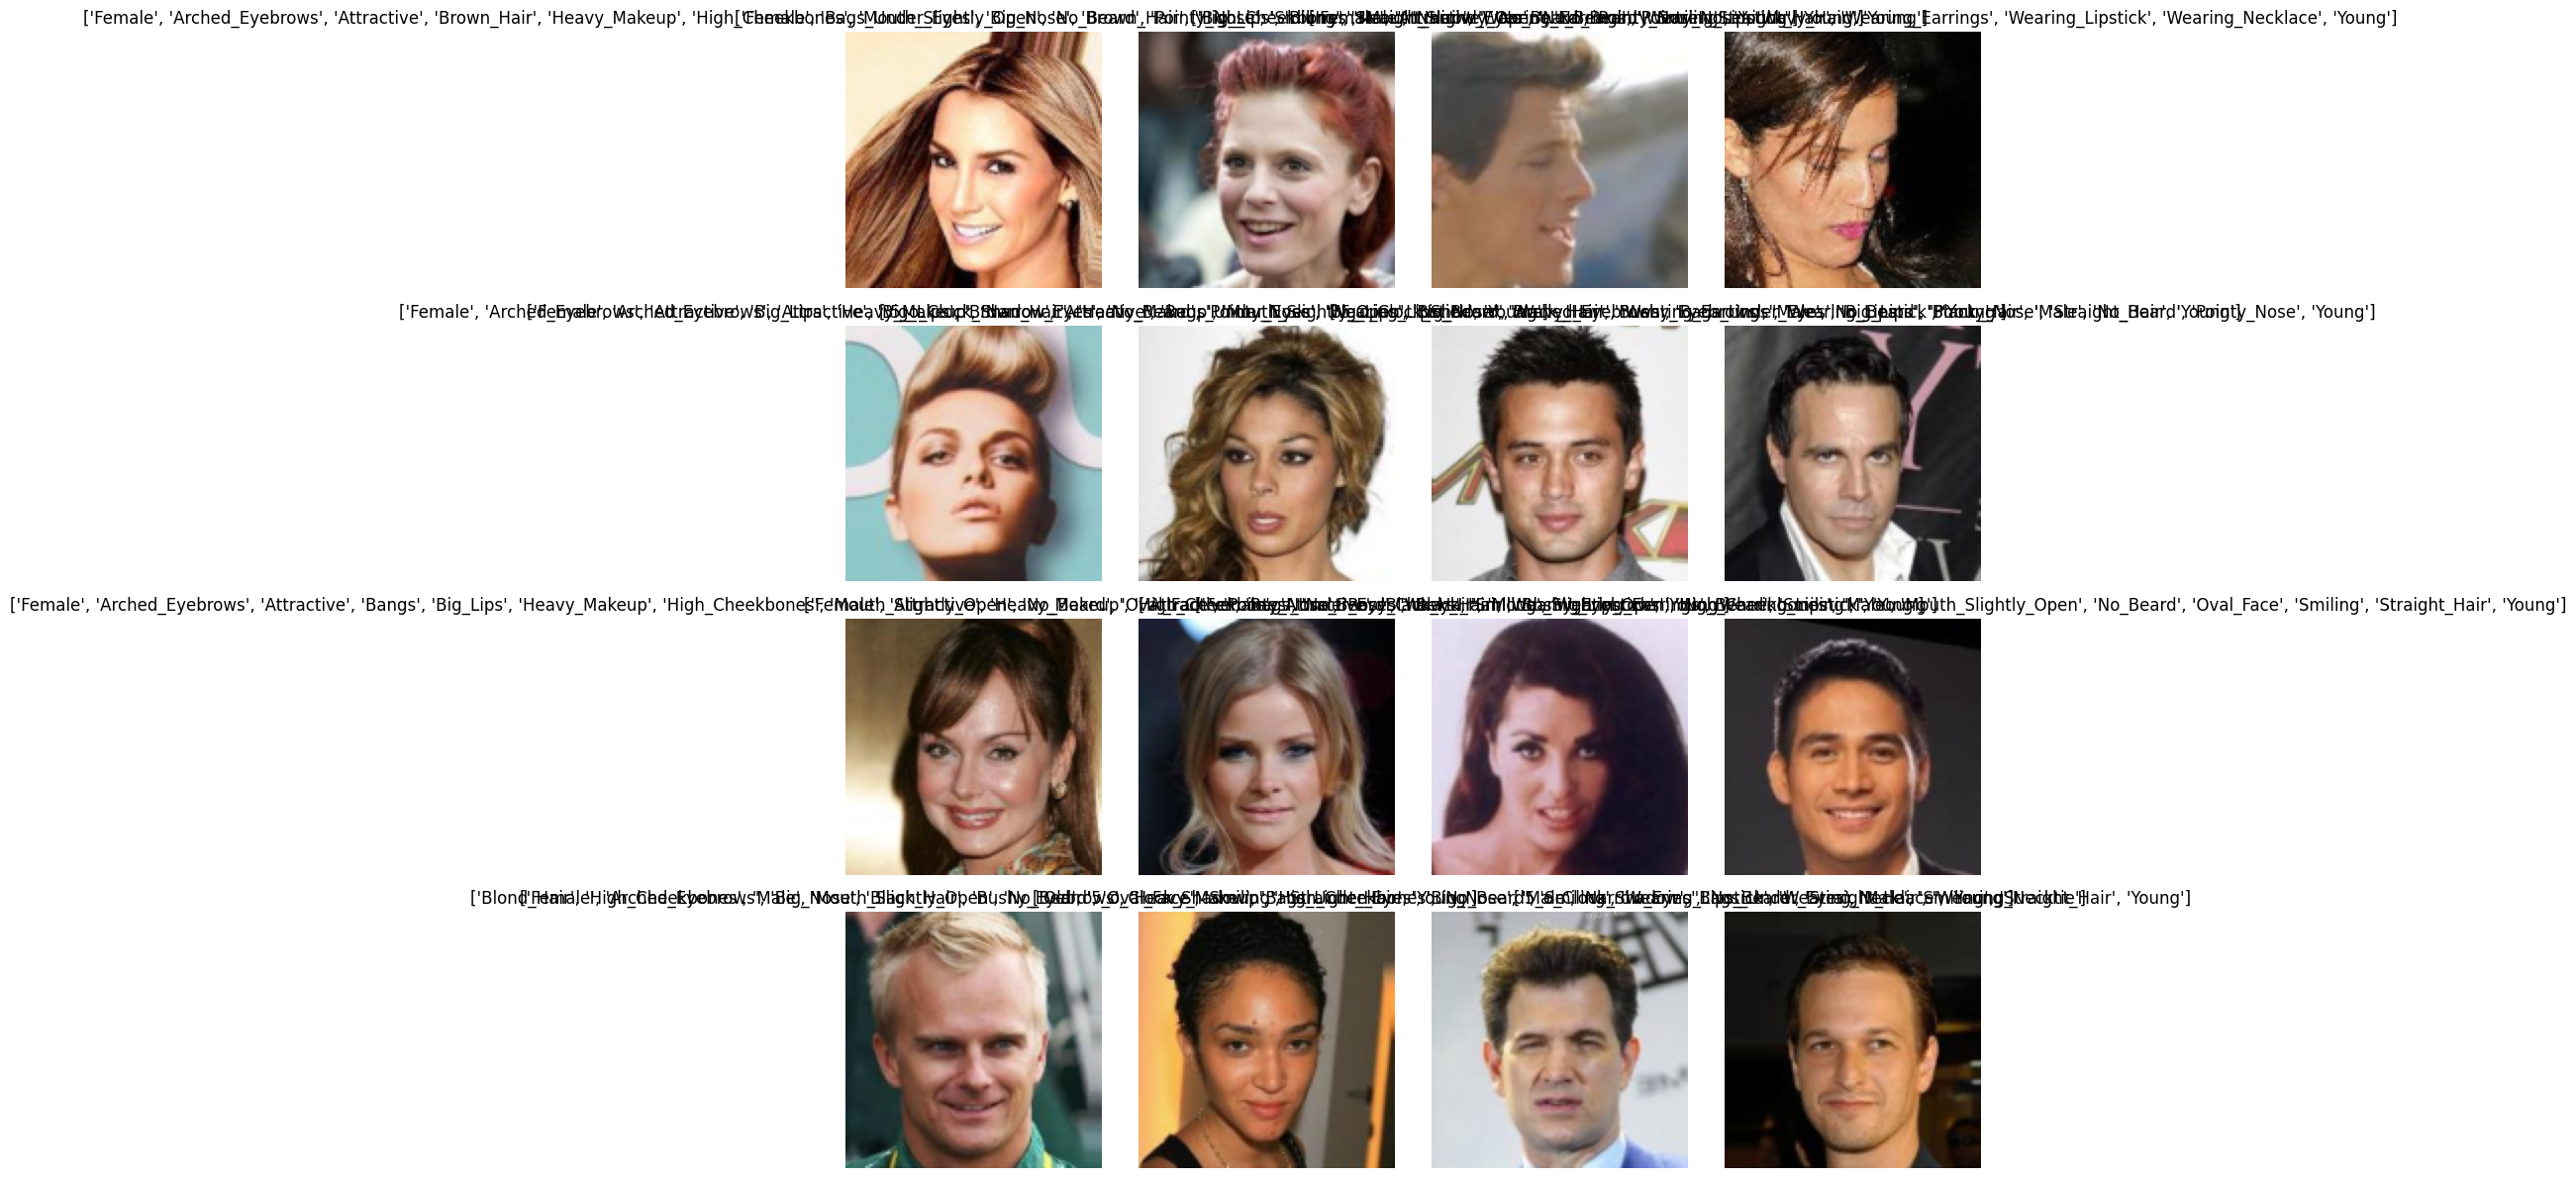

In [81]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        image = images[i] * 0.5 + 0.5
        image = image.permute(1, 2, 0).numpy()
        label_idx = [idx2attr[i] for i, label in enumerate(labels[i].numpy().tolist()) if label == 1.0]
        label_names = [selected_attrs[idx] for idx in label_idx]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(label_names)
    plt.tight_layout()
    plt.show()

images, labels = zip(*[dataset[i] for i in range(16)])
plot_images(images, labels)

In [73]:
young_idx = len(selected_attrs) - 1
young_pairs = [i for i, label in enumerate(dataset.labels) if label[young_idx] != 1]


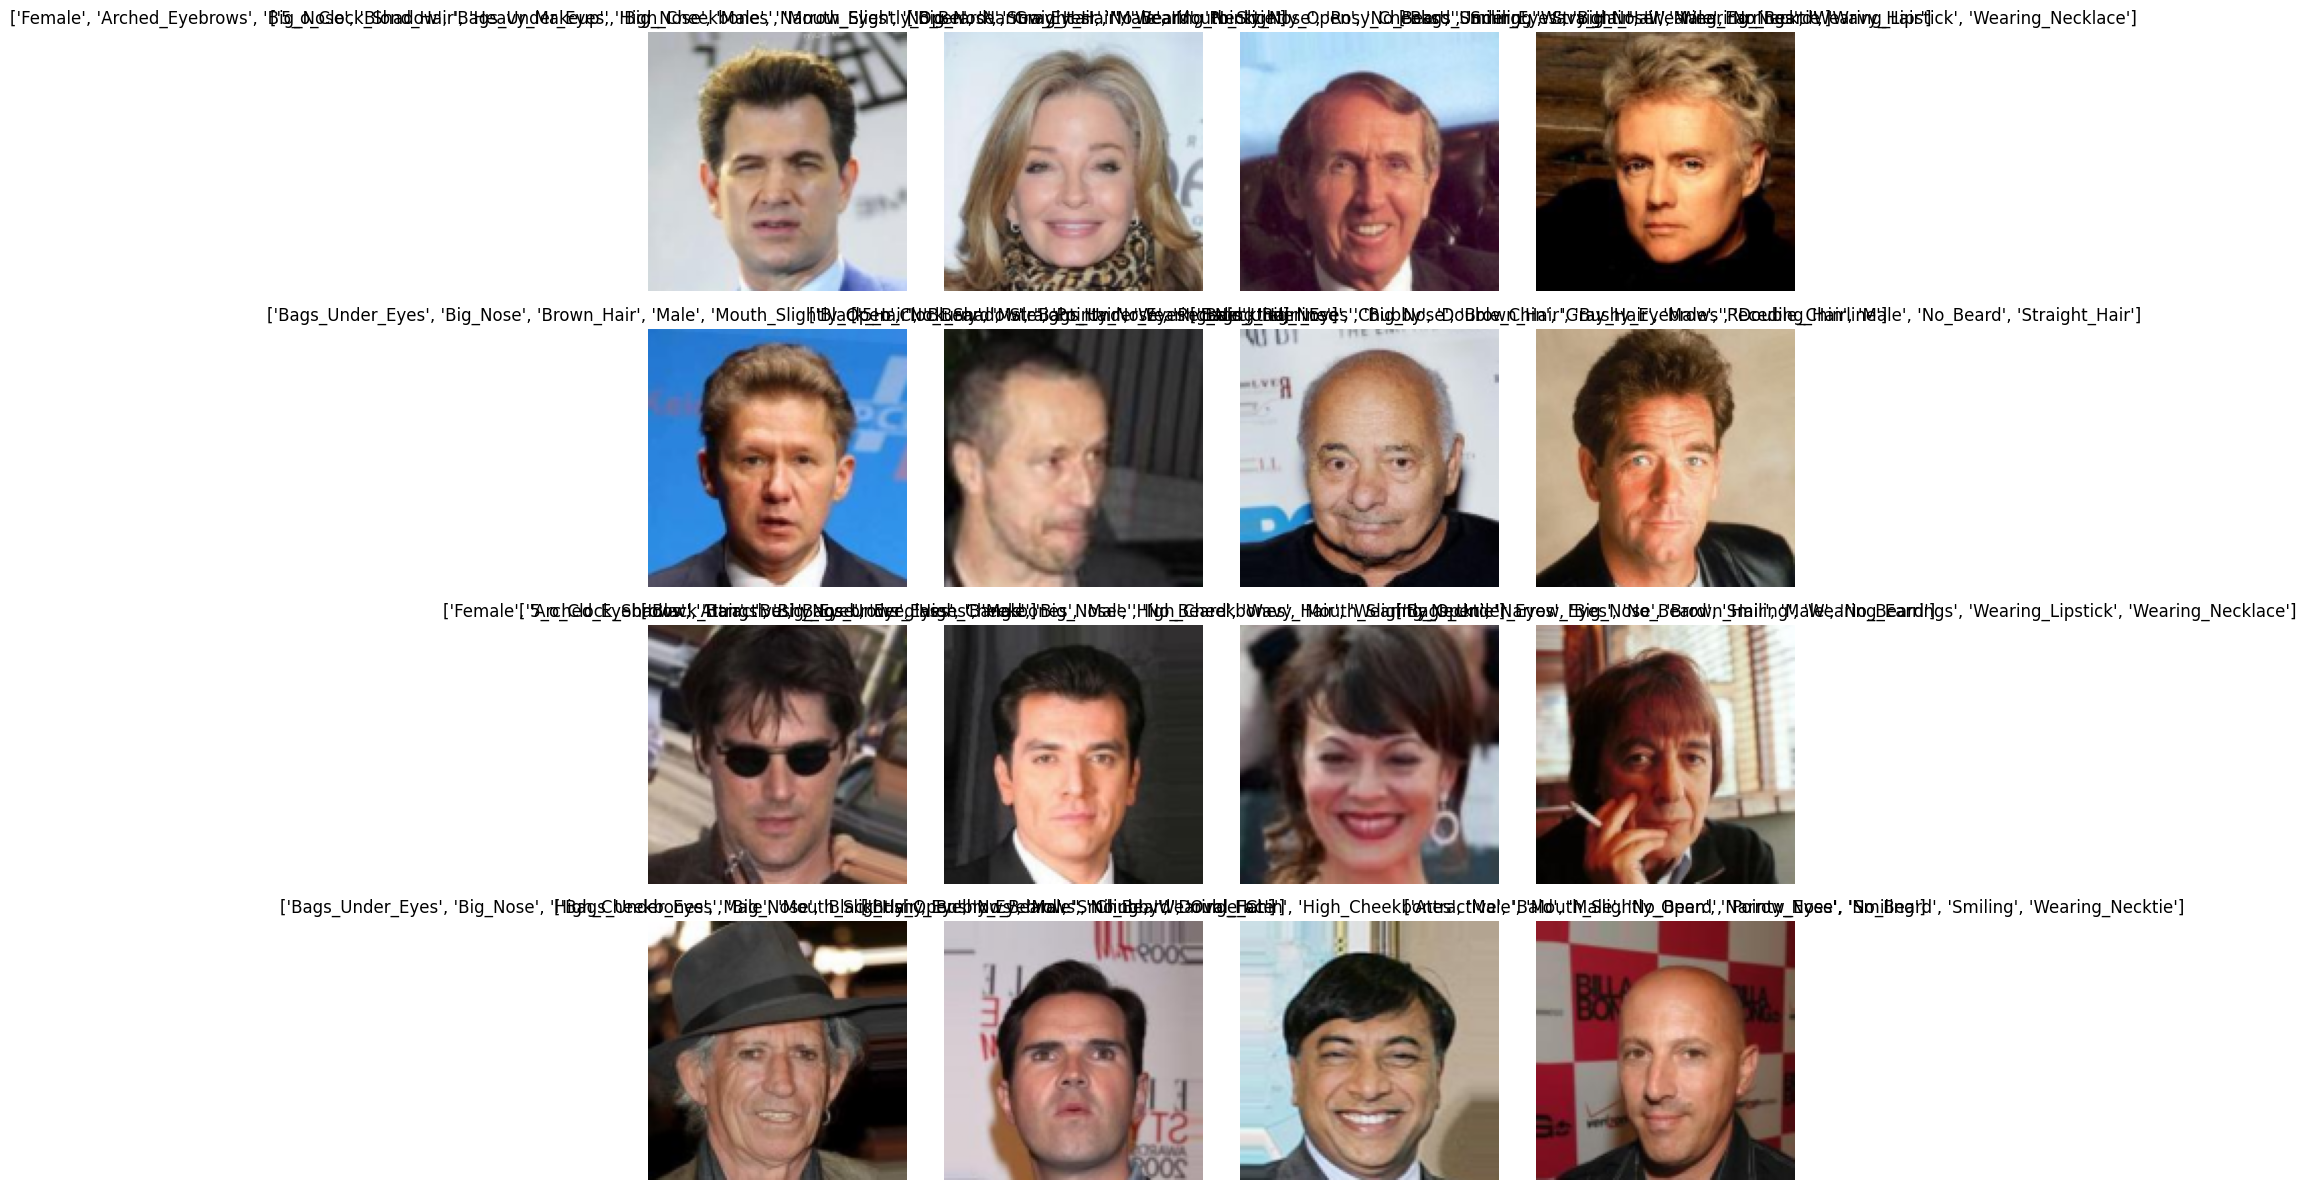

In [74]:
plot_images([dataset[i][0] for i in young_pairs[:16]], [dataset[i][1] for i in young_pairs[:16]])

In [83]:
value_counts = np.zeros(len(selected_attrs))

for label in dataset.labels:
    value_counts += label

print(value_counts)

[ 45865. 118165.  22516.  54090. 103833.  41446.   4547.  30709.  48785.
  47516.  48472.  29983.  10312.  41572.  28803.  11663.   9459.  13193.
  12716.   8499.  78390.  92189.  84434.  97942.   8417.  23329. 169158.
  57567.   8701.  56210.  16163.  13315.  11449.  97669.  42222.  64744.
  38276.   9818.  95715.  24913.  14732. 156734.]


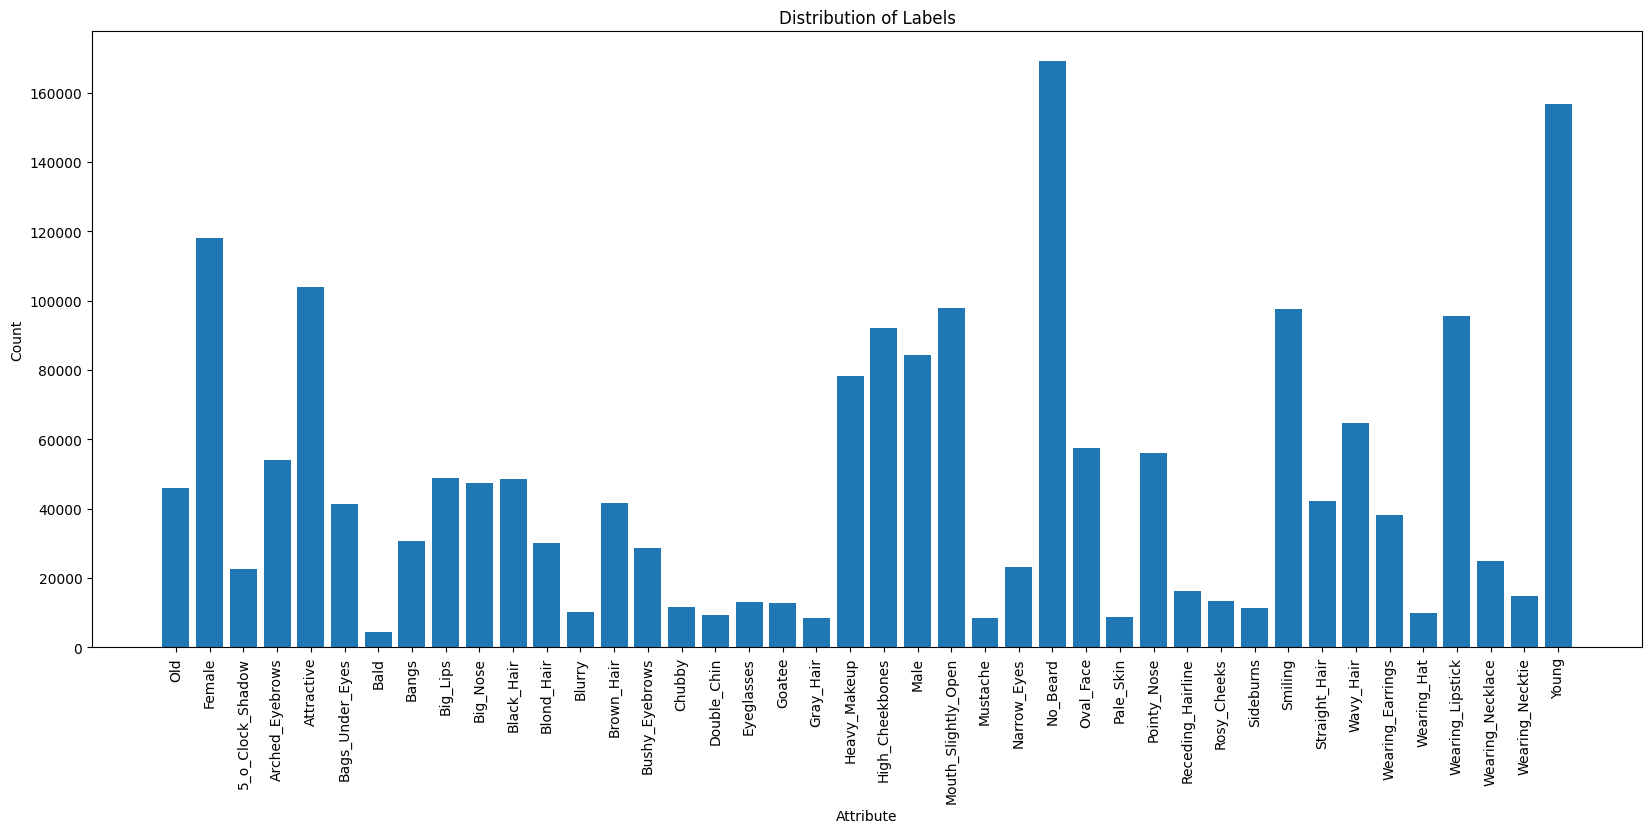

In [84]:
plt.figure(figsize=(20, 8))
plt.bar(range(len(value_counts)), value_counts)
plt.xticks(range(len(value_counts)), [selected_attrs[idx] for idx in selected_attrs.keys()], rotation=90)
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [85]:
selected_attrs_over_40000 = {attr: selected_attrs[attr] for attr in selected_attrs if value_counts[attr2idx[attr]] > 40000}
print(selected_attrs_over_40000)

{-2: 'Old', -1: 'Female', 1: 'Arched_Eyebrows', 2: 'Attractive', 3: 'Bags_Under_Eyes', 6: 'Big_Lips', 7: 'Big_Nose', 8: 'Black_Hair', 11: 'Brown_Hair', 18: 'Heavy_Makeup', 19: 'High_Cheekbones', 20: 'Male', 21: 'Mouth_Slightly_Open', 24: 'No_Beard', 25: 'Oval_Face', 27: 'Pointy_Nose', 31: 'Smiling', 32: 'Straight_Hair', 33: 'Wavy_Hair', 36: 'Wearing_Lipstick', 39: 'Young'}


In [89]:
selected = {
    -2: 'Old',
    -1: 'Female',
    8: 'Black_Hair',
    11: 'Brown_Hair',
    #18: 'Heavy_Makeup',
    20: 'Male',
    #32: 'Straight_Hair',
    #33: 'Wavy_Hair',
    #36: 'Wearing_Lipstick',
    39: 'Young'
}

In [91]:
dataset = CelebA(data_dir, split, selected, transform)
print(len(dataset.images))

images, labels = zip(*[dataset[i] for i in range(16)])

202599


In [92]:
label_org = labels[0]
rand_idx = torch.randperm(label_org.size(0))  # size: config.num_classes
label_trg = label_org[rand_idx]
print(label_org, label_trg)

tensor([0., 1., 0., 1., 0., 1.]) tensor([0., 1., 1., 0., 1., 0.])
